<a href="https://colab.research.google.com/github/danisswift/Major_Project/blob/dev/workinprogress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import glob
import music21

Prepare the data and parse it into a Music21 notes array

In [2]:
notes = []
for file in glob.glob("midi_songs/*.mid"):
  midi = music21.converter.parse(file)
print("Parsing %s" % file)
notes_to_parse = None
try:
  s2 = music21.instrument.partitionByInstrument(midi)
  notes_to_parse = s2.parts[0].recurse() 
             
except: 
  notes_to_parse = midi.flat.notes
  
for element in notes_to_parse:
  if isinstance(element, music21.note.Note):
    notes.append(str(element.pitch))
  elif isinstance(element, music21.chord.Chord):
    notes.append('.'.join(str(n) for n in element.normalOrder))


Parsing midi_songs/ss-14.mid


In [3]:
import pickle

In [4]:
with open('/content/notes/notes', 'wb') as filepath:
        pickle.dump(notes, filepath)

In [5]:
pitchnames = sorted(set(item for item in notes))
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

In [6]:
import numpy
import tensorflow
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import BatchNormalization as BatchNorm
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

Create a mapping function to map the notes to integer-based numerical data

In [7]:
n_vocab = len(set(notes))
sequence_length = 100

# get all pitch names
pitchnames = sorted(set(item for item in notes))

  # create a dictionary to map pitches to integers
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

network_input = []
network_output = []

# create input sequences and the corresponding outputs
for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])

n_patterns = len(network_input)

# reshape the input into a format compatible with LSTM layers
network_input = numpy.reshape(network_input, (n_patterns, sequence_length, 1))
# normalize input
network_input = network_input / float(n_vocab)

network_output = np_utils.to_categorical(network_output)

Design the model architecture for an LSTM

In [8]:
model = Sequential()
model.add(LSTM(512,input_shape=(network_input.shape[1], network_input.shape[2]),
               return_sequences=True))

model.add(Dropout(0.3))
model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(512))
model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Dense(n_vocab))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

In [9]:
filepath = 'weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5'
checkpoint = ModelCheckpoint(
filepath,
monitor='loss',
verbose=0,
save_best_only=True,
mode='min'
)
callbacks_list = [checkpoint]

Train the model using Keras and the data we prepared earlier

In [11]:
model.fit(network_input, network_output, epochs=100, batch_size=64, callbacks=callbacks_list)

Epoch 1/100
10/10 [==============================] - 76s 8s/step - loss: 3.8349
Epoch 2/100
10/10 [==============================] - 74s 7s/step - loss: 3.8120
Epoch 3/100
10/10 [==============================] - 73s 7s/step - loss: 3.7703
Epoch 4/100
10/10 [==============================] - 76s 8s/step - loss: 3.7647
Epoch 5/100
10/10 [==============================] - 78s 8s/step - loss: 3.7801
Epoch 6/100
10/10 [==============================] - 75s 7s/step - loss: 3.7640
Epoch 7/100
10/10 [==============================] - 75s 7s/step - loss: 3.7428
Epoch 8/100
10/10 [==============================] - 73s 7s/step - loss: 3.7588
Epoch 9/100
10/10 [==============================] - 72s 7s/step - loss: 3.7500
Epoch 10/100
10/10 [==============================] - 73s 7s/step - loss: 3.7239
Epoch 11/100
10/10 [==============================] - 75s 7s/step - loss: 3.7577
Epoch 12/100
10/10 [==============================] - 74s 7s/step - loss: 3.7320
Epoch 13/100
10/10 [=================

In [13]:
import matplotlib.pyplot as plt


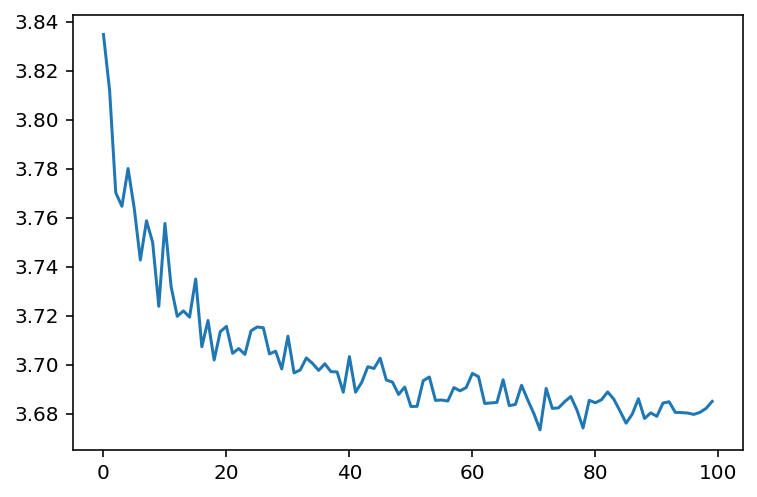

In [14]:
plt.plot(model.history.epoch, model.history.history['loss'], label='total loss')
plt.show()

In [15]:
from google.colab import files

In [16]:
!mkdir -p models

In [17]:
model.save('models/model_1')

INFO:tensorflow:Assets written to: models/model_1/assets


INFO:tensorflow:Assets written to: models/model_1/assets


In [18]:
!zip -r /content/models/model_1.zip /content/models/model_1

updating: content/models/model_1/ (stored 0%)
updating: content/models/model_1/assets/ (stored 0%)
updating: content/models/model_1/keras_metadata.pb (deflated 92%)
updating: content/models/model_1/variables/ (stored 0%)
updating: content/models/model_1/variables/variables.data-00000-of-00001 (deflated 6%)
updating: content/models/model_1/variables/variables.index (deflated 67%)
updating: content/models/model_1/saved_model.pb (deflated 91%)


In [19]:
with open('/content/notes/notes', 'rb') as filepath:
        notes = pickle.load(filepath)

Use the model to generate new notes

At the minute, the starting sequence is random, but this will be changed to be a custom input from the user

In [ ]:
# pick a random sequence from the input as a starting point for the prediction
start = numpy.random.randint(0, len(network_input)-1)

int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

pattern = network_input[start]
prediction_output = []

# generate 500 notes
for note_index in range(500):
    prediction_input = numpy.reshape(pattern, (1, len(pattern), 1))
    prediction_input = prediction_input / float(n_vocab)

    prediction = model.predict(prediction_input, verbose=0)

    index = numpy.argmax(prediction)
    result = int_to_note[index]
    prediction_output.append(result)

    pattern = numpy.append(pattern, index)
    #print(pattern)
    pattern = pattern[1:len(pattern)]

Mapping function to decode the result produced by the model back to music notes

In [21]:
offset = 0
output_notes = []

# create note and chord objects based on the values generated by the model
for pattern in prediction_output:
    # pattern is a chord
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
            new_note = music21.note.Note(int(current_note))
            new_note.storedInstrument = music21.instrument.AcousticGuitar()
            notes.append(new_note)
        new_chord = music21.chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
    # pattern is a note
    else:
        new_note = music21.note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = music21.instrument.AcousticGuitar()
        output_notes.append(new_note)

    # increase offset each iteration so that notes do not stack
    offset += 0.5

In [22]:
midi_stream = music21.stream.Stream(output_notes)

#midi_stream.write('midi', fp='test_output.mid')

In [23]:
!pip install pretty_midi

In [24]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fluidsynth is already the newest version (1.1.9-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [25]:
!pip install --upgrade pyfluidsynth

In [26]:
import pretty_midi
midi_stream.write('midi', fp='test_output.mid')
pm = pretty_midi.PrettyMIDI('test_output.mid')

In [27]:
from IPython import display
# Sampling rate for audio playback
_SAMPLING_RATE = 16000
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

Play the produced music

In [28]:
display_audio(pm)